In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
path = r'../data/AER_credit_card_data.csv'
df = pd.read_csv(path)

In [3]:
# shape
df.shape

(1319, 12)

In [4]:
# top 5 records
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [5]:
# missing values
df.isnull().mean()

card           0.0
reports        0.0
age            0.0
income         0.0
share          0.0
expenditure    0.0
owner          0.0
selfemp        0.0
dependents     0.0
months         0.0
majorcards     0.0
active         0.0
dtype: float64

## Data preparation

In [6]:
df['card'] = (df['card'] == "yes").astype(np.uint8)

In [7]:
df['card'].value_counts(normalize=True)

1    0.775588
0    0.224412
Name: card, dtype: float64

In [8]:
### Train test split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=1)
train_df, test_df = train_test_split(train_df, test_size=0.25, random_state=1)

In [9]:
train_df.shape, val_df.shape, test_df.shape

((791, 12), (264, 12), (264, 12))

### q1
Which numerical variable (among the following 4) has the highest AUC?

- reports
- dependents
- active
- share

In [10]:
cols = ['reports', 'dependents', 'active', 'share']
scores = []
for col in cols:
    if roc_auc_score(df.card, df[{col}]) < 0.5:
        scores.append((col, roc_auc_score(df.card, -df[{col}])))
    else:
        scores.append((col, roc_auc_score(df.card, df[{col}])))
    print(f'AUC score for {col} is {roc_auc_score(df.card, df[{col}])}')
sorted(scores, key=lambda x: -x[1])

AUC score for reports is 0.28219862090829834
AUC score for dependents is 0.4742278935827323
AUC score for active is 0.5824680985971309
AUC score for share is 0.9898054212570342


[('share', 0.9898054212570342),
 ('reports', 0.7178013790917016),
 ('active', 0.5824680985971309),
 ('dependents', 0.5257721064172676)]

### q2
Use the following features
["reports", "age", "income", "share", 
 "expenditure", "dependents", "months", 
 "majorcards", "active", "owner", "selfemp"]
 
 What's the AUC of this model on the validation dataset? (round to 3 digits)

In [11]:
def data_prep(x, fill_method='zero', model='logreg'):
    x = x.copy().reset_index(drop=True)
    y = x['card']
    del x['card']
    return x, y

In [12]:
def one_hot_and_append_feat(x, cols, is_train=True):
    dicts = x[cols].to_dict(orient='records')
    if is_train:
        dv.fit(dicts)
    one_hot_df = pd.DataFrame(dv.transform(dicts), columns=dv.get_feature_names())
    x = x.reset_index(drop=True)
    x = pd.concat([x, one_hot_df], axis=1)
    return x.drop(cols, axis=1)

In [13]:
dv = DictVectorizer(sparse=False)

In [14]:
cat_cols = train_df.select_dtypes(include='object').columns

In [15]:
cat_cols

Index(['owner', 'selfemp'], dtype='object')

In [16]:
# prepare train, val and test splits
train_df, train_y = data_prep(train_df)
val_df, val_y = data_prep(val_df)
test_df, test_y = data_prep(test_df)

train_df = one_hot_and_append_feat(train_df, cat_cols)
val_df = one_hot_and_append_feat(val_df, cat_cols, is_train=False)
test_df = one_hot_and_append_feat(test_df, cat_cols, is_train=False)

In [17]:
train_df.head()

,reports,age,income,share,expenditure,dependents,months,majorcards,active,owner=no,owner=yes,selfemp=no,selfemp=yes
0,3,40.50000,4.0128,0.000299,0.00000,1,12,1,17,1.0,0.0,1.0,0.0
1,1,32.33333,6.0000,0.000200,0.00000,4,18,1,4,0.0,1.0,1.0,0.0
2,1,29.16667,2.2000,0.038205,69.79333,0,49,1,7,1.0,0.0,1.0,0.0
3,1,54.66667,7.2900,0.106536,647.20670,2,78,1,9,0.0,1.0,1.0,0.0
4,0,25.00000,3.3984,0.000353,0.00000,2,29,0,4,0.0,1.0,1.0,0.0


In [18]:
train_df.shape, val_df.shape, test_df.shape

((791, 13), (264, 13), (264, 13))

In [19]:
log_reg = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=1)

In [20]:
log_reg.fit(train_df, train_y)

LogisticRegression(max_iter=1000, random_state=1, solver='liblinear')

In [21]:
# prediction on val dataset
val_pred = log_reg.predict_proba(val_df)[:, 1]
roc_auc_score(val_y, val_pred)

0.9954086317722682

### q3

Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
For each threshold, compute precision and recall
Plot them
At which threshold precision and recall curves intersect?

In [22]:
precision_scores = []
recall_scores = []
num = int((1-0)/.01)
thresholds = np.linspace(0, 1, num+1)
for threshold in thresholds:
    val_pred_t = val_pred >= threshold
    precision_scores.append(precision_score(val_y, val_pred_t))
    recall_scores.append(recall_score(val_y, val_pred_t))
    

In [23]:
# threhold intersection
thresholds[np.isclose(precision_scores, recall_scores, rtol=0.0001, atol=0.009)]

array([0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28])

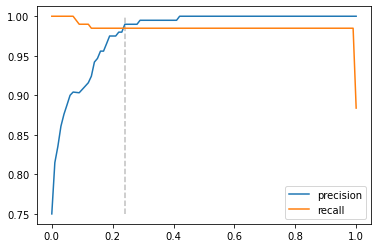

In [24]:
plt.plot(thresholds, precision_scores, label='precision')
plt.plot(thresholds, recall_scores, label='recall')
plt.vlines(0.24, 0.75, 1, color='grey', linestyle='--', alpha=0.5)
plt.legend()
plt.show()

In [25]:
# for t, a, b in zip(thresholds, precision_scores, recall_scores):
#     print(t, a, b, abs(a-b))

### q4
Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01
At which threshold F1 is maximal?

In [26]:
f1_scores = []
num = int((1-0)/.01)
thresholds = np.linspace(0, 1, num+1)
for threshold in thresholds:
    val_pred_t = val_pred >= threshold
    f1_scores.append(f1_score(val_y, val_pred_t))

In [27]:
sorted(dict(zip(thresholds, f1_scores)).items(), key=lambda x: -x[1])[:5]

[(0.42, 0.9923664122137404),
 (0.43, 0.9923664122137404),
 (0.44, 0.9923664122137404),
 (0.45, 0.9923664122137404),
 (0.46, 0.9923664122137404)]

### q5
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:
    How large is standard devidation of the AUC scores across different folds?

In [28]:
colums_to_use = ["reports", "age", "income", "share", 
                 "expenditure", "dependents", "months", 
                 "majorcards", "active", "owner", "selfemp"]

In [29]:
def data_prep(x, is_train=True):
    dicts = x[colums_to_use].to_dict(orient='records')
    if is_train:
        dv.fit(dicts)
    X = pd.DataFrame(dv.transform(dicts), columns=dv.get_feature_names())
    return X
    

In [30]:
def build_model(X, y, C=1.0):
    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X, y)
    return model

In [31]:
def predict(X, model):
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred

In [32]:
def cross_val(df, C=1, 
              n_splits=5, 
              random_state=1):
    auc_scores = []
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    for train_idx, val_idx in kf.split(df):
        train_x = df.iloc[train_idx]
        val_x = df.iloc[val_idx]
        train_y = train_x["card"]
        val_y = val_x["card"]
        train_x = data_prep(train_x)
        val_x = data_prep(val_x, is_train=False)
        model = build_model(train_x, train_y, C)
        preds = predict(val_x, model)
        auc_scores.append(roc_auc_score(val_y, preds))
    return auc_scores
    
    

In [33]:
### Train test split
train_full_df, val_df = train_test_split(df, test_size=0.2, random_state=1)

In [34]:
dv = DictVectorizer(sparse=False)
scores = cross_val(train_full_df)

In [35]:
np.std(scores)

0.0027434713804377724

### q6
Now let's use 5-Fold cross-validation to find the best parameter C

Iterate over the following C values: [0.01, 0.1, 1, 10]
Initialize KFold with the same parameters as previously
Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
Compute the mean score as well as the std (round the mean and std to 3 decimal digits)
Which C leads to the best mean score?

In [36]:
C = [0.01, 0.1, 1, 10]
res = []
for c in C:
    dv = DictVectorizer(sparse=False)
    scores = cross_val(train_full_df, C=c)
    res.append([c, np.mean(scores), np.std(scores)]) 

In [37]:
res_df = pd.DataFrame(res, columns=['C', 'mean', 'std'])

In [38]:
res_df.sort_values(['mean', 'std', 'C'], ascending=[False, True, True])

,C,mean,std
2,1.00,0.996450,0.002743
3,10.00,0.996389,0.002815
1,0.10,0.995056,0.003954
0,0.01,0.991881,0.005599
